# МОДЕЛИРОВАНИЕ СИСТЕМЫ ХРАНЕНИЯ ДАННЫХ

## ОПИСАНИЕ

*Задача проекта (User Story):*

Я, как product owner хочу уметь расчитывать производительность из параметров железа     
Чтобы снизить затраты производства и повысить предсказуемость характеристик продукта

*Критерии приемки:*

* Возможность восстановить параметры железа по производительности

* Модель должна выводить сравнительные графики: сырой даты и предсказанной

* Вывод метрик модели (R², средние квадраты и тд.)



## СОДЕРЖАНИЕ

* [Configuration](#configuration)
    * [Libraries](#libraries)
    * [Documentation](#documentation)
* [Research Data](#research-data)
    * [Reader](#reader)
    * [Converter](#converter)
    * [Writer](#writer)
    * [OHE module](#one-hot-encoder-module)
* [Analysis](#анализ)
    * [Raw Data](#raw-data)
        * [Distribution](#distribution)
        * [Correlation matrix](#correlation-matrix)
        * [Visualization](#visualization)
    * [Modelling](#modelling)
        * [Data transformation](#data-transformation)
        * [Model training](#model-training)
* [Summaries](#summaries)

## Configuration

### Libraries

In [84]:
import pymc as pm
import arviz as az
import numpy as np
import pandas as pd
import xarray as xr
import itertools
import seaborn as sns
import re
import glob
import matplotlib.pyplot as plt

In [11]:
folder_path = 'Correct sizes'  # Path of raw data

### Documentation

Фиксируем возможные значения параметров, описываем их тип.

In [12]:
doc = {'protection': ['2REP', '3REP', 'EC2.1'],  #cat. # maybe more types later
       'size': [8, 128, 1e3, 128e3],  # cont.
       'nodes': np.linspace(4, 16, 13, dtype = int),  # cont.
       'type': ['write', 'read'],  # cat.
       'HW_chassis': ['X205', 'VEGMAN'],  # cat.
       'SSD': [2, 4]  # cont.
      }

cat_params = ['protection', 'type', 'HW_chassis']
cont_params = ['size', 'nodes', 'SSD']

all_options = np.array(list(itertools.product( *(doc[key] for key in list(doc.keys())) )))

all_options_w_ops = np.concatenate((all_options, [[0] for _ in range(len(all_options))]), axis = 1)


**Установим общий вид .txt / .md файла замера**

```
protection=<protecrion_value>
HW_chassis=<hardware_chassis_value>
SSD=<number_of_ssd>

### <number_of_nodes> nodes <object's_size> <type> // begin of size
INFO[<time>] Load started at: <date> (<timezone>) source=<source_value> 
INFO[<time>] Load finished at: <date> (<timezone>)source=<source_value>   
█ setup

\``` // _begin of block with size results from one installation_
 █ teardown

 aws_obj_put_bytes......: <float> <unit_of_measurement>  <float><unit_of_measurement>/s
 
 aws_obj_put_duration...: avg=<float><unit_of_measurement> min=<float><unit_of_measurement> med=<float><unit_of_measurement> max=<float><unit_of_measurement> p(90)=<float><unit_of_measurement>  p(95)=<float><unit_of_measurement>
 aws_obj_put_success....: <float> <float>/s
 data_received..........: <float> <unit_of_measurement> <float> <unit_of_measurement>/s
 data_sent..............: <float> <unit_of_measurement> <float> <unit_of_measurement>/s
 iteration_duration.....: avg=<float><unit_of_measurement> min=<float><unit_of_measurement> med=<float><unit_of_measurement> max=<float><unit_of_measurement> p(90)=<float><unit_of_measurement>  p(95)=<float><unit_of_measurement>
 iterations.............: <float> <float>/s
 vus....................: <float> min=<float> max=<float>
\``` // _end of block with size results from one installation_
// there can be several blocks for one size
```

## Research Data

### Reader

Скрипт читает все файлы замеров и переводит замеры в словарь ```Data```, в котором ключи --- параметры железа.

Структура ```Data```: $$\left\{\begin{pmatrix}protection \\ size \\ nodes \\ w/r \\ HW\_chassis \\ SSD \end{pmatrix}:\;\begin{Bmatrix}MB/s: & list \\ avg: & list\\ min: & list \\ med: & list \\ max: & list \\ p(90): & list \\ p(95): & list \\ op/s: & list \\ op/s\_loss: & list \\ SUM\_MB/s: & float \\ SUM\_op/s: & float\end{Bmatrix}\right\}$$

In [13]:
txt_files = glob.glob(f"{folder_path}/*.txt")
md_files = glob.glob(f"{folder_path}/*.md")

all_files = txt_files + md_files


Data = dict()

for file_path in all_files:
    with open(file_path, 'r', encoding='utf-8') as file:
        
        ###
        lines = file.readlines()
        data = []
        for line in lines:
            data.append( line.strip().split(' ') )


        file_protection = [temp_data[0].split('=')[1].upper() for temp_data in data if 'protection' in temp_data[0]][0]
 
        file_HW_chassis = [temp_data[0].split('=')[1].upper() for temp_data in data if 'HW_chassis' in temp_data[0]][0]

        file_SSD = [int(temp_data[0].split('=')[1]) for temp_data in data if 'SSD' in temp_data[0]][0]
  
        i = 0
        counter = 0
        print(str(data).count('###'),f'correct number of sizes {file_path}')
        # realization of data reading functions
        while i < len(data):
            
            if '###' in data[i]:
                counter += 1
                Params = dict.fromkeys(list(doc.keys()))
                for temp in list( Params.keys() ):
                    Params[temp] = 0
                
                temp_data_0 = [k for k in data[i] if len(k) > 0]
                
                Params['protection'] = file_protection
                Params['SSD'] = file_SSD
                Params['nodes'] = int(temp_data_0[1])
                Params['type'] =  temp_data_0[4].lower()
                Params['HW_chassis'] = file_HW_chassis
                
                if re.fullmatch( r'(\b\d*kb\b)', str( temp_data_0[3] ).lower()):  # size like kb
                    Params['size'] = float(temp_data_0[3][:-2])
                elif re.fullmatch( r'(\b\d*kib\b)', str( temp_data_0[3] ).lower() ):  #size like kib
                    Params['size'] = float(temp_data_0[3][:-3])
                elif re.fullmatch( r'(\b\d*mb\b)', str( temp_data_0[3] ).lower() ):  #size like mb
                    Params['size'] = float(temp_data_0[3][:-2]) * 1000  # convert to KB
                elif re.fullmatch( r'(\b\d*mib\b)', str( temp_data_0[3] ).lower() ):  #size like mib
                    Params['size'] = float(temp_data_0[3][:-3]) * 1000
                else:
                    Params['size'] = 'INCORRECT DATA'
                
                i += 1
                
                Input = dict.fromkeys(['MB/s', 'avg', 'min', 'med', 'max', 'p(90)', 'p(95)','op/s','op/s_loss', 'SUM_MB/s','SUM_op/s'])
                for temp in list( Input.keys() ):
                    Input[temp] = []
                '''
                op/s_loss --- perfomance fails
                SUM_MB/s, SUM_op/s --- SUM of perfomance in MB/s, op/s
                '''

                while i < len(data) - 1 and not('###' in data[i+1]):
                    
                    if 'aws_obj_get_bytes' in str(data[i]) or 'aws_obj_put_bytes' in str(data[i]):
                        temp_data = [k for k in data[i] if len(k) > 0]
                        if str(temp_data[-1]).lower() == 'mb/s':
                            Input['MB/s'].append(float(temp_data[-2]))
                        elif str(temp_data[-1]).lower() == 'gb/s':
                            Input['MB/s'].append(float(temp_data[-2]) * 1000)  # convert to mb/s
                        else:
                            Input['MB/s'].append('INCORRECT DATA')
                    
                    if 'aws_obj_get_duration' in str(data[i]) or 'aws_obj_put_duration' in str(data[i]):
                        temp_data = [k.split('=') for k in data[i] if len(k) > 0]
                        for j in range(1,6+1):                            
                            if 'ms' in str(temp_data[j][1]).lower():  # case M.SECONDS
                                Input[temp_data[j][0]].append(float(temp_data[j][1][:-2]))  # we suppose that notation <digits>m<digits><MS> is impossible 
                                    
                            else:  # case SECONDS 
                                match = re.fullmatch( r'(\b\d*\dm\d\d*\w*\b)', str(temp_data[j][1]).lower() )  # <digits (at least 1)>m<digits (at least 1)><s> - found m in d[b][1] in seconds
                                if match:
                                    Input[temp_data[j][0]].append((float(str(temp_data[j][1][:-1]).split('m')[0]) * 60 + float(str(temp_data[j][1][:-1]).split('m')[1])) * 1000)  # convert to ms| found m
                                else:
                                    Input[temp_data[j][0]].append(float(temp_data[j][1][:-1]) * 1000)  # convert to ms
            
                    if 'aws_obj_put_success' in str(data[i]) or 'aws_obj_get_success' in str(data[i]):
                        temp_data = [k for k in data[i] if len(k) > 0]
                        Input['op/s'].append(float(temp_data[2][:-2:]))  #obj/s
                        
            
                    if 'aws_obj_get_fails' in str(data[i]):
                        temp_data = [k for k in data[i] if len(k) > 0]
                        Input['op/s_loss'].append(float(temp_data[2][:-2:]))  #obj/s
                    i += 1
                ### found '###' or end of file, update our Data                    
                
                # realization of agregate functions 
                Input['SUM_MB/s'] = np.sum(Input['MB/s'])
                Input['SUM_op/s'] = np.sum(Input['op/s'])
                
                ###
                
                Data[tuple(Params.values())] = Input
            i += 1
                        
    print(counter, f'get number of sizes {file_path}')


39 correct number of sizes Correct sizes\Sizer results for rep3.txt
39 get number of sizes Correct sizes\Sizer results for rep3.txt
61 correct number of sizes Correct sizes\Sizer_results_1.txt
61 get number of sizes Correct sizes\Sizer_results_1.txt
40 correct number of sizes Correct sizes\sizer_results_8nodes_rep2 (2).md
40 get number of sizes Correct sizes\sizer_results_8nodes_rep2 (2).md
56 correct number of sizes Correct sizes\sizer_results_ec2.1_retest_actual.md
56 get number of sizes Correct sizes\sizer_results_ec2.1_retest_actual.md


### Converter

Конвертирует словарь ```Data``` в список ```Data_list```.

In [14]:
Data_list = []
for key in list(Data.keys()):
    Data_list.append(list(key) + list(Data[key].values()) )
Header = list(Params.keys())
for key in list(Data.keys()):
    Header += list(Data[key].keys())
    break

### Writer

Записывает ```Data_list``` в .xlsx файл.

In [ ]:
df = pd.DataFrame(Data_list, columns = Header)
df.to_excel('output.xlsx', index=False, header=True)


KeyboardInterrupt



### One Hot Encoder

Переводит строковые категориальные признаки в унитарные.

In [15]:
def features_transformation(Data: dict, doc = doc) -> pd.DataFrame:  # CHECK CODE AFTER EVERY UPDATE!
    X = np.array([list(key) + [Data[key]['SUM_op/s']] for key in list(Data.keys())])
    Y = all_options_w_ops # massive of all posible key values, target values = 0
    X = np.vstack((X, Y))
    header = list(doc.keys()); header.append('SUM_op/s')
    X_OHE_DF = pd.get_dummies(pd.DataFrame(X, columns = header), columns = cat_params, prefix = cat_params)  # cat params
    X_OHE_DF['size'] = X_OHE_DF['size'].astype(float)
    X_OHE_DF['nodes'] = X_OHE_DF['nodes'].astype(int)
    X_OHE_DF['SUM_op/s'] = X_OHE_DF['SUM_op/s'].astype(float)
    X_OHE_DF['SSD'] = X_OHE_DF['SSD'].astype(int)
    X_OHE_DF = X_OHE_DF.replace({True: 1, False: 0}).infer_objects(copy=False)
    return (X_OHE_DF.drop(['protection_2REP', 'type_read', 'HW_chassis_VEGMAN'], axis=1, inplace=False)).head(len(Data))  # drop collinear columns - CAN CHANGES

In [16]:
print(features_transformation(Data))  # debug

C:\Users\shiri\AppData\Local\Temp\ipykernel_17104\4015556992.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_OHE_DF = X_OHE_DF.replace({True: 1, False: 0}).infer_objects(copy=False)


         size  nodes  SSD      SUM_op/s  protection_3REP  protection_EC2.1  \
0         8.0     16    2   9680.554701                1                 0   
1         8.0     16    2  20065.334488                1                 0   
2       128.0     16    2   5681.330100                1                 0   
3       128.0     16    2  18788.737276                1                 0   
4      1000.0     16    2   2042.689679                1                 0   
..        ...    ...  ...           ...              ...               ...   
189     128.0      4    2   1936.546119                0                 1   
190    1000.0      4    2    646.974487                0                 1   
191    1000.0      4    2    797.192718                0                 1   
192  128000.0      4    2      7.994045                0                 1   
193  128000.0      4    2     11.903917                0                 1   

     type_write  HW_chassis_X205  
0             1             

## Analysis

### Raw Data

Посмотрим, как ведёт себя целевое значение на имеющихся данных вдоль выбранного параметра при фиксированных прочих.

In [17]:
def compare (key: tuple, parametr: str, fix_params: dict) -> bool:
    i = 0
    while str(parametr) != str(list(fix_params.keys())[i]):
        if str(key[i]) != str(list(fix_params.values())[i]):
            return 0
            break
        i += 1
    i += 1
    while i < len(list(fix_params.keys())):
        if str(key[i]) != str(list(fix_params.values())[i]):
            return 0
            break
        i += 1
    return 1

def key_enum (param: str, doc = doc):
    i = 0
    while i < len(list(doc.keys())):
        if str(param) == str(list(doc.keys())[i]):
            return i
            break
        i += 1
    return 'ERROR'

In [18]:
params = list(doc.keys())
print(f'remember, that there is some params we must to fix: \n{params}\nimportant: now we`re working with raw data - what we put, that we get\n\ncontinious parametrs:\n{cont_params}\n\ncategorial parametrs:\n{cat_params}')

remember, that there is some params we must to fix: 
['protection', 'size', 'nodes', 'type', 'HW_chassis', 'SSD']
important: now we`re working with raw data - what we put, that we get

continious parametrs:
['size', 'nodes', 'SSD']

categorial parametrs:
['protection', 'type', 'HW_chassis']


#### Distribution

C:\Users\shiri\AppData\Local\Temp\ipykernel_17104\4015556992.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_OHE_DF = X_OHE_DF.replace({True: 1, False: 0}).infer_objects(copy=False)
C:\Users\shiri\AppData\Local\Temp\ipykernel_17104\4015556992.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_OHE_DF = X_OHE_DF.replace({True: 1, False: 0}).infer_objects(copy=False)
C:\Users\shiri\AppData\Local\Temp\ipykernel_17104\4015556992.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a fu

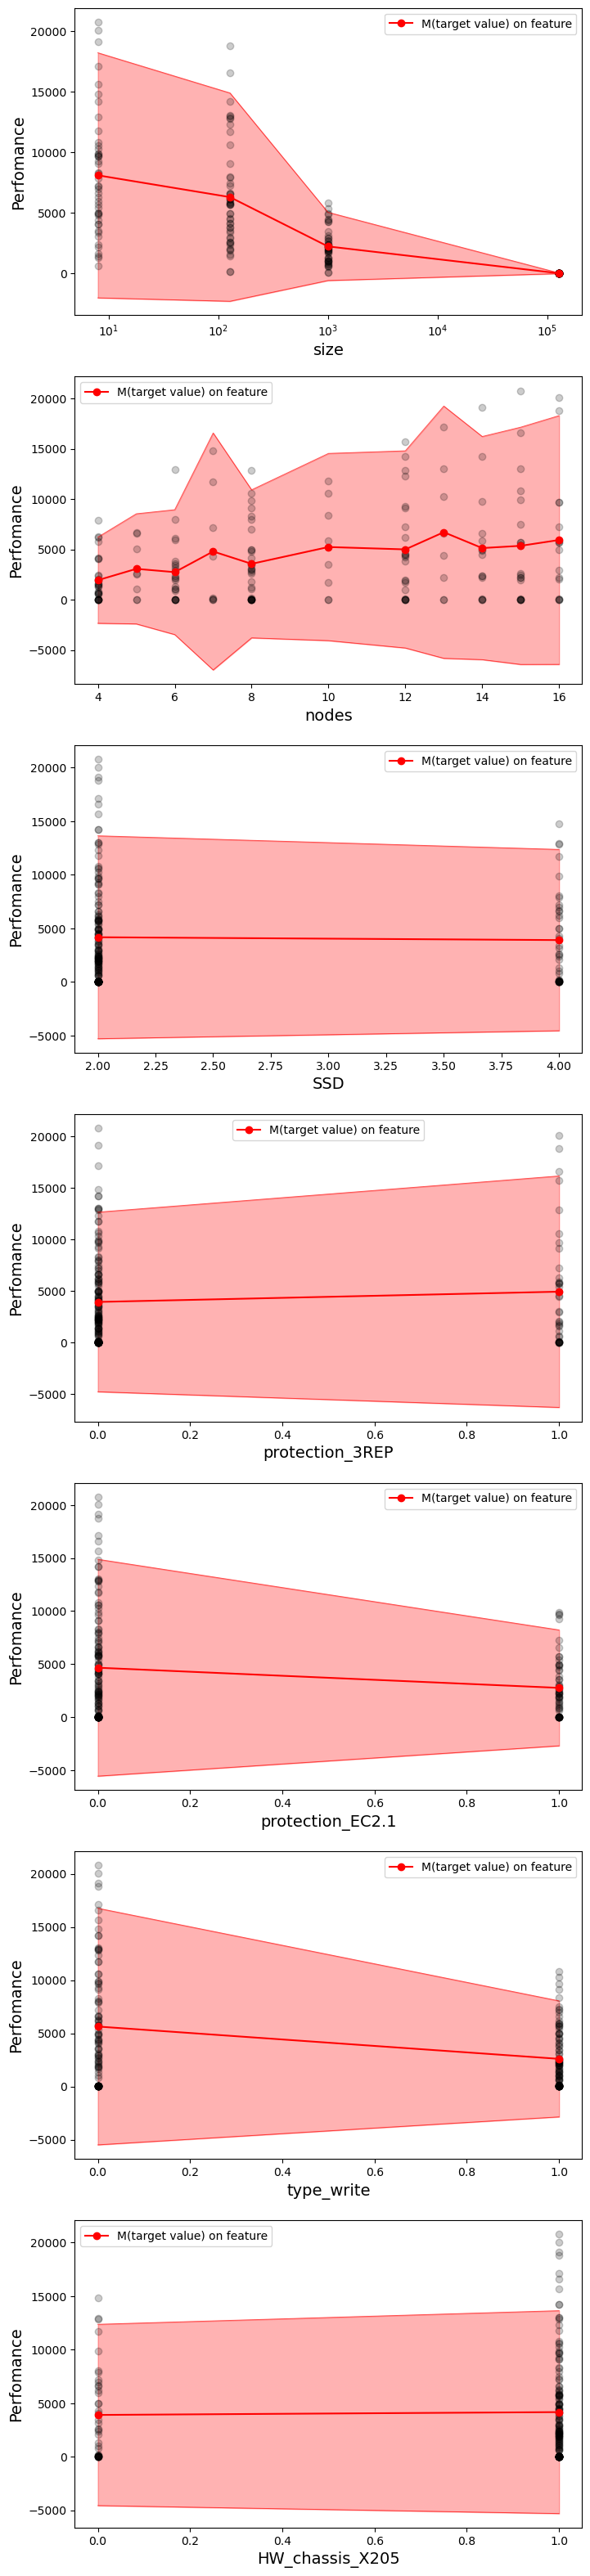

In [107]:
plt.figure(figsize=(8,40))
header_temp = list(features_transformation(Data).columns)
header_temp.remove('SUM_op/s')
n = len(header_temp)
for i in range(n):
    plt.subplot(n,1,i + 1)
    if header_temp[i] == 'size':
        plt.xscale('symlog')
    else:
        plt.xscale('linear')
    X = list(features_transformation(Data)[header_temp[i]])
    Y = list(features_transformation(Data)['SUM_op/s'])
    mean_values = features_transformation(Data).groupby(header_temp[i])['SUM_op/s'].mean().reset_index()
    mean_values.columns = ['X', 'Mean_Y']
    var_values = features_transformation(Data).groupby(header_temp[i])['SUM_op/s'].var().reset_index()
    var_values.columns = ['X', 'Var_Y']
    plt.plot(mean_values['X'], mean_values['Mean_Y'], color='red', marker='o', label='M(target value) on feature')
    plt.plot(var_values['X'], mean_values['Mean_Y'] + 2 * np.sqrt(var_values['Var_Y']), color='red', alpha = 0.6, linewidth = 0.7)
    plt.plot(var_values['X'], mean_values['Mean_Y'] - 2 * np.sqrt(var_values['Var_Y']), color='red', alpha = 0.6, linewidth = 0.7)
    plt.fill_between(
        var_values['X'], mean_values['Mean_Y'] - 2 * np.sqrt(var_values['Var_Y']), 
        mean_values['Mean_Y'] + 2 * np.sqrt(var_values['Var_Y']), 
        where=(
            mean_values['Mean_Y'] + 2 * np.sqrt(var_values['Var_Y']) > mean_values['Mean_Y'] - 2 * np.sqrt(var_values['Var_Y'])
            ), color='red', alpha=0.3
            )
    plt.scatter(X, Y, color='black', marker='o', alpha=0.2)
    plt.title('', fontsize=15)
    plt.xlabel(header_temp[i], fontsize=14, color='k')
    plt.ylabel('Perfomance', fontsize=14, color='k')
    plt.legend()
    

#### Correlation matrix

C:\Users\shiri\AppData\Local\Temp\ipykernel_17104\4015556992.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_OHE_DF = X_OHE_DF.replace({True: 1, False: 0}).infer_objects(copy=False)


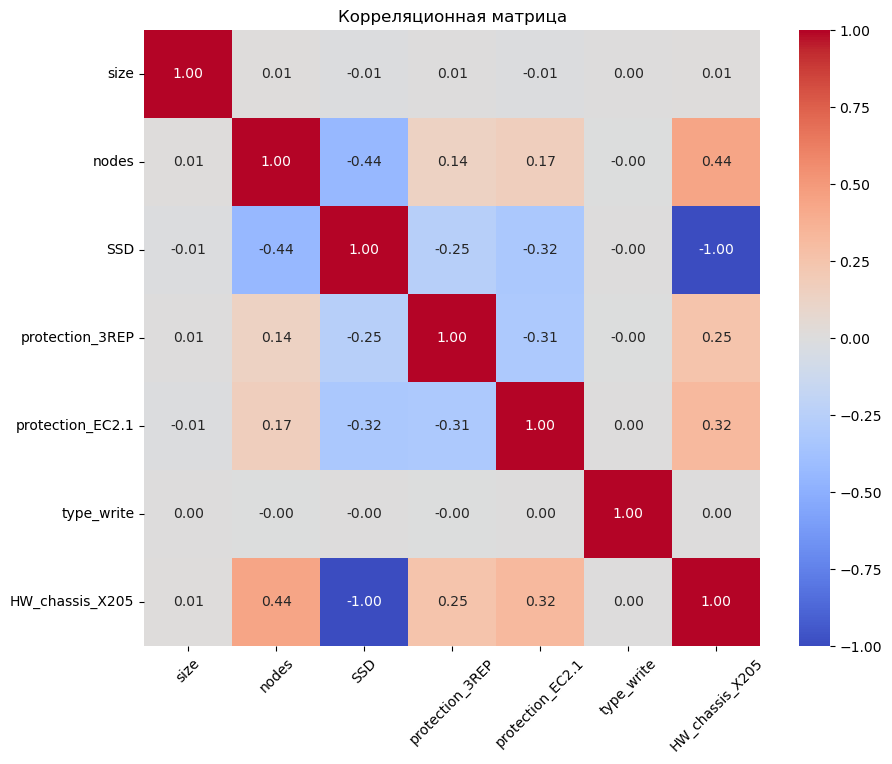

In [90]:
df = features_transformation(Data).drop('SUM_op/s', axis=1)
correlation_matrix = df.corr()
plt.figure(figsize=(10, 8))
hmap = sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True)
hmap.set_xticklabels(hmap.get_xmajorticklabels(), rotation=45)
plt.title('Корреляционная матрица')
plt.show()
sns.reset_orig()

**Вывод из матрицы корреляции**  
*Будем считать, что два признака кореллированы, если их коэффициент корреляции по модулю превосходит $0.7$.*  
Видно, что признаки `SSD` и `HW_chassis_X205` линейно зависимы, это объясняется тем, что замеры на `HW_chassis` = "X205" проводились при `SSD` = 2, а, замеры на `HW_chassis` = "VEGMAN" проводились при `SSD` = 4.  
Зависимость не значима.

#### Visualization

In [109]:
parametr = 'nodes'
'''
It's an Ox' value
(Oy always is a target value --- perfomance)
'''

### fix other params for detail searching (order as in documentation dictionary - it`s important)
fix_params = {
    'protection': '3REP',
    'size': 1e3,
    'nodes': 15,
    'type': 'read',
    'HW_chassis': 'X205',
    'SSD': 2
}
### we can define here other pack of params for compare
fix_params_2 = {
    'protection': '3REP',
    'size': 128e3,
    'nodes': 8,
    'type': 'write',
    'HW_chassis': 'X205',
    'SSD': 2
}
###

params:
           first graph second graph
protection        3REP         3REP
size            1000.0     128000.0
type              read        write
HW_chassis        X205         X205
SSD                  2            2


Text(0, 0.5, 'Op per sec')

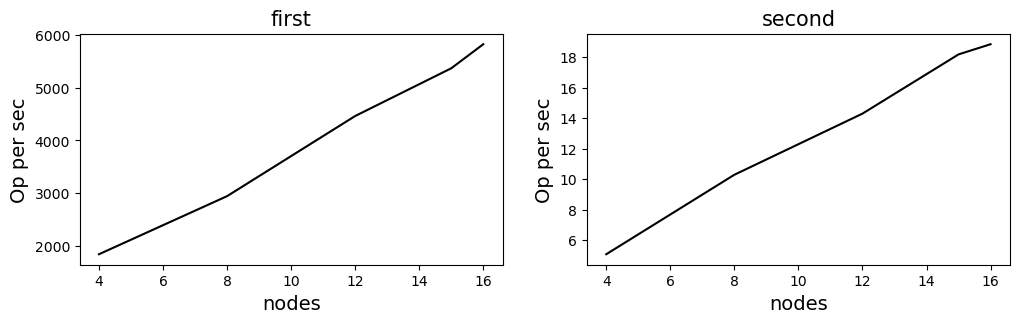

In [110]:
Z = np.array((
    [
        key[key_enum(parametr)] for key in list(Data.keys()) if compare(key, parametr, fix_params)
    ],
    [
        Data[key]['SUM_op/s'] for key in list(Data.keys()) if compare(key, parametr, fix_params)
    ]
)).T

W = np.array((
    [
        key[key_enum(parametr)] for key in list(Data.keys()) if compare(key, parametr, fix_params_2)
    ],
    [
        Data[key]['SUM_op/s'] for key in list(Data.keys()) if compare(key, parametr, fix_params_2)
    ]
)).T

plt.figure(figsize=(12, 3)) 

plt.subplot(1, 2, 1)
plt.xscale('linear')

Z = Z[Z[:, 0].argsort()].T; W = W[W[:, 0].argsort()].T

graph_title = {key: {'first graph': fix_params[key], 'second graph': fix_params_2[key]} for key in list(doc.keys())}

plt.plot(Z[0], Z[1],'k-', alpha = 1)
graph_title.pop(parametr, None)
print(f'params:\n{pd.DataFrame(graph_title).transpose()}')
plt.title('first', fontsize=15)
plt.xlabel(parametr, fontsize=14, color='k')
plt.ylabel('Op per sec', fontsize=14, color='k')


plt.subplot(1, 2, 2)
plt.xscale('linear')
plt.plot(W[0], W[1],'k-', alpha = 1)
plt.title('second', fontsize=15)
plt.xlabel(parametr, fontsize=14, color='k')
plt.ylabel('Op per sec', fontsize=14, color='k')




Из графиков выше, мы должны понять характер роста производительности

### Modelling

_about_: использованы байесовские методы из PyMC.

#### Data transformation

Линейная модель, PyMC $$predict = \boldsymbol{weights}\cdot \boldsymbol{features} + intercept$$

#### Model training

In [111]:

X = np.concatenate(
        (
            np.array(features_transformation(Data))[:, :3], np.array(features_transformation(Data))[:, 4:]
        ), axis = 1) # predictor
Y = np.array(features_transformation(Data))[:, 3] # target
print(X.shape)


C:\Users\shiri\AppData\Local\Temp\ipykernel_17104\4015556992.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_OHE_DF = X_OHE_DF.replace({True: 1, False: 0}).infer_objects(copy=False)
C:\Users\shiri\AppData\Local\Temp\ipykernel_17104\4015556992.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_OHE_DF = X_OHE_DF.replace({True: 1, False: 0}).infer_objects(copy=False)
C:\Users\shiri\AppData\Local\Temp\ipykernel_17104\4015556992.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a fu

(194, 7)


In [134]:
def G(X: np.ndarray) -> np.ndarray:
    return np.exp( - (X- 1e2) ** 2 / 25e2)

In [160]:


# X: 194 x 7
size = X[:, 0]
nodes = X[:, 1]
SSD = X[:, 2]
protection_3REP = X[:, 3]
protection_EC21 = X[:, 4]
type_write = X[:, 5]
HW_chassis_X205 = X[:, 6]

# Определение модели линейной регрессии
with pm.Model() as model:
    # Определение параметров
    intercept = pm.Normal('intercept', mu=0, sigma=10)
    slope_size_linear = pm.Normal('slope_size_linear', mu=0, sigma=1e2)
    slope_size_gaussian = pm.Normal('slope_size_gaussian', mu=0, sigma=5e3)
    slope_nodes_linear= pm.Normal('slope_nodes_linear', mu=0, sigma=25e2)
    slope_nodes_log= pm.Normal('slope_nodes_log', mu=0, sigma=5e2)
    slope_SSD = pm.Normal('slope_SSD', mu=0, sigma=4e3)
    slope_protection_3REP = pm.Normal('slope_protection_3REP', mu=0, sigma=4e3)
    slope_protection_EC21 = pm.Normal('slope_protection_EC21', mu=0, sigma=75e2 / 2)
    slope_type_write = pm.Normal('slope_type_write', mu=0, sigma=75e2 / 2)
    slope_HW_chassis_X205 = pm.Normal('slope_HW_chassis_X205', mu=0, sigma=75e2 / 2)
    

    sigma = pm.HalfNormal('sigma', sigma=1)

    # Определение линейной модели
    y_obs = pm.Normal(
        'y_obs', 
        mu = intercept + 
        slope_size_linear * X[:, 0] + slope_size_gaussian * G(X[:, 0]) + 
        slope_nodes_linear * X[:, 1] + slope_nodes_log * np.log(X[:, 1]) +
        slope_SSD * X[:, 2] + 
        slope_protection_3REP * X[:, 3] + 
        slope_protection_EC21 * X[:, 4] + 
        slope_type_write * X[:, 5] + 
        slope_HW_chassis_X205 * X[:, 6], 
        sigma=sigma, observed=Y 
        )

    # Сэмплирование
    trace = pm.sample(1000, tune=1000)



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [intercept, slope_size_linear, slope_size_gaussian, slope_nodes_linear, slope_nodes_log, slope_SSD, slope_protection_3REP, slope_protection_EC21, slope_type_write, slope_HW_chassis_X205, sigma]


c:\Users\shiri\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 537 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [161]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,0.496,10.227,-18.308,19.653,0.211,0.227,2344.0,1625.0,1.0
slope_size_linear,-0.040,0.000,-0.041,-0.040,0.000,0.000,1704.0,1283.0,1.0
slope_size_gaussian,1781.127,50.141,1687.915,1876.534,1.154,0.816,1888.0,1485.0,1.0
slope_nodes_linear,256.304,19.994,216.518,290.562,0.831,0.589,574.0,825.0,1.0
slope_nodes_log,1178.354,170.916,862.545,1494.014,7.262,5.138,551.0,772.0,1.0
slope_SSD,690.734,47.246,608.483,783.249,1.959,1.386,576.0,826.0,1.0
slope_protection_3REP,-280.500,45.093,-363.606,-193.878,1.060,0.763,1818.0,1474.0,1.0
slope_protection_EC21,-2469.206,38.774,-2546.079,-2394.951,0.896,0.634,1864.0,1454.0,1.0
slope_type_write,-3033.567,29.776,-3086.461,-2974.048,0.651,0.460,2072.0,1332.0,1.0
slope_HW_chassis_X205,906.514,100.295,722.105,1092.980,4.074,2.882,606.0,918.0,1.0


C:\Users\shiri\AppData\Local\Temp\ipykernel_17104\3789046039.py:33: RuntimeWarning: divide by zero encountered in log
  np.mean(slope_nodes_linear_samples) * X_range[:, 1] + np.mean(slope_nodes_log_samples) * np.log(X_range[:, 1]) +


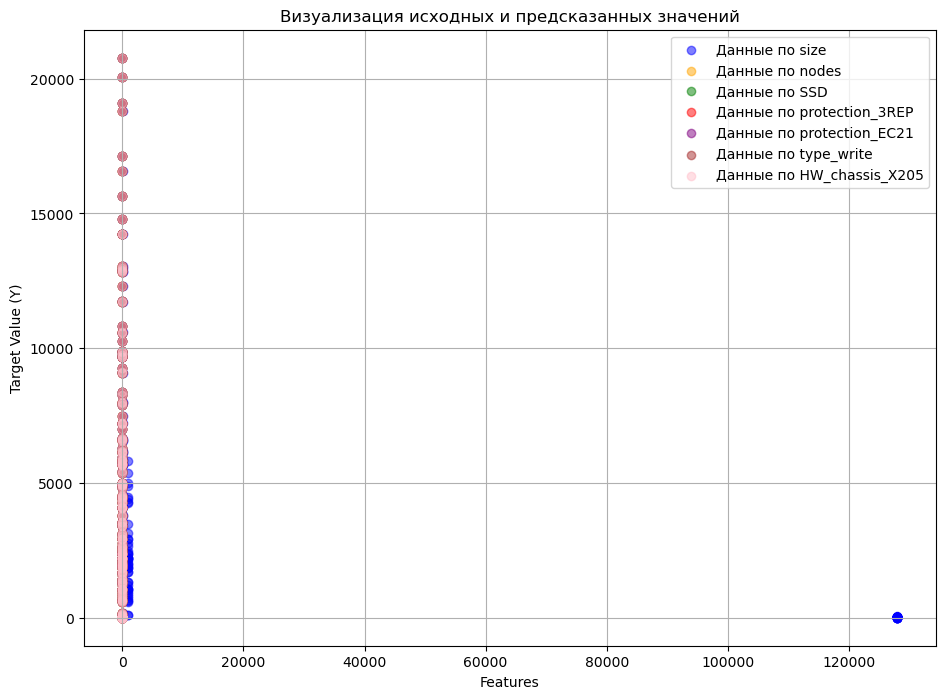

In [162]:
# Анализ результатов
# Визуализация параметров с использованием arviz
#az.plot_trace(trace)
#plt.show()

# Извлечение параметров из trace
intercept_samples = trace.posterior['intercept'].values.flatten()
slope_size_linear_samples = trace.posterior['slope_size_linear'].values.flatten()
slope_size_gaussian_samples = trace.posterior['slope_size_gaussian'].values.flatten()
slope_nodes_linear_samples = trace.posterior['slope_nodes_linear'].values.flatten()
slope_nodes_log_samples = trace.posterior['slope_nodes_log'].values.flatten()
slope_SSD_samples = trace.posterior['slope_SSD'].values.flatten()
slope_protection_3REP_samples = trace.posterior['slope_protection_3REP'].values.flatten()
slope_protection_EC21_samples = trace.posterior['slope_protection_EC21'].values.flatten()
slope_type_write_samples = trace.posterior['slope_type_write'].values.flatten()
slope_HW_chassis_X205_samples = trace.posterior['slope_HW_chassis_X205'].values.flatten()

# Построение предсказаний
x_range_size = np.linspace(8, 128e3, int(127993 * 10e-3))
x_range_nodes = np.linspace(0, 100, 100)
x_range_SSD = np.linspace(2, 4, 2)
x_range_protection_3REP = np.linspace(0, 1, 2)
x_range_protection_EC21 = np.linspace(0, 1, 2)
x_range_type_write = np.linspace(0, 1, 2)
x_range_HW_chassis_X205 = np.linspace(0, 1, 2)
X_range = np.array(np.meshgrid(
    x_range_size, x_range_nodes, x_range_SSD, x_range_protection_3REP, x_range_protection_EC21, x_range_type_write, x_range_HW_chassis_X205
    )).T.reshape(-1, 7)

y_pred = (
    np.mean(intercept_samples) + 
    np.mean(slope_size_linear_samples) * X_range[:, 0] + np.mean(slope_size_gaussian_samples) * G(X_range[:, 0]) +
    np.mean(slope_nodes_linear_samples) * X_range[:, 1] + np.mean(slope_nodes_log_samples) * np.log(X_range[:, 1]) +
    np.mean(slope_SSD_samples) * X_range[:, 2] +
    np.mean(slope_protection_3REP_samples) * X_range[:, 3] +
    np.mean(slope_protection_EC21_samples) * X_range[:, 4] +
    np.mean(slope_type_write_samples) * X_range[:, 5] +
    np.mean(slope_HW_chassis_X205_samples) * X_range[:, 6]
)
# Визуализация предсказаний
plt.figure(figsize=(11, 8))

# Визуализация исходных данных
plt.scatter(X[:, 0], Y, alpha=0.5, label='Данные по size', color='blue')
plt.scatter(X[:, 1], Y, alpha=0.5, label='Данные по nodes', color='orange')
plt.scatter(X[:, 2], Y, alpha=0.5, label='Данные по SSD', color='green')
plt.scatter(X[:, 3], Y, alpha=0.5, label='Данные по protection_3REP', color='red')
plt.scatter(X[:, 4], Y, alpha=0.5, label='Данные по protection_EC21', color='purple')
plt.scatter(X[:, 5], Y, alpha=0.5, label='Данные по type_write', color='brown')
plt.scatter(X[:, 6], Y, alpha=0.5, label='Данные по HW_chassis_X205', color='pink')


plt.xlabel('Features')
plt.ylabel('Target Value (Y)')
plt.title('Визуализация исходных и предсказанных значений')
plt.legend()
plt.grid(True)
plt.show()


In [177]:
parametr = 'nodes'
'''
It's an Ox' value
(Oy always is a target value --- perfomance)
'''

### fix other params for detail searching (order as in documentation dictionary - it`s important)
fix_params = {
    'protection': '3REP',
    'size': 1e3,
    'nodes': 15,
    'type': 'read',
    'HW_chassis': 'X205',
    'SSD': 2
}


params:
           first graph
protection        3REP
size            1000.0
type              read
HW_chassis        X205
SSD                  2


C:\Users\shiri\AppData\Local\Temp\ipykernel_17104\3342483837.py:36: RuntimeWarning: divide by zero encountered in log
  np.mean(slope_nodes_linear_samples) * X_range[:, 0] + np.mean(slope_nodes_log_samples) * np.log(X_range[:, 0]) +


Text(0, 0.5, 'Op per sec')

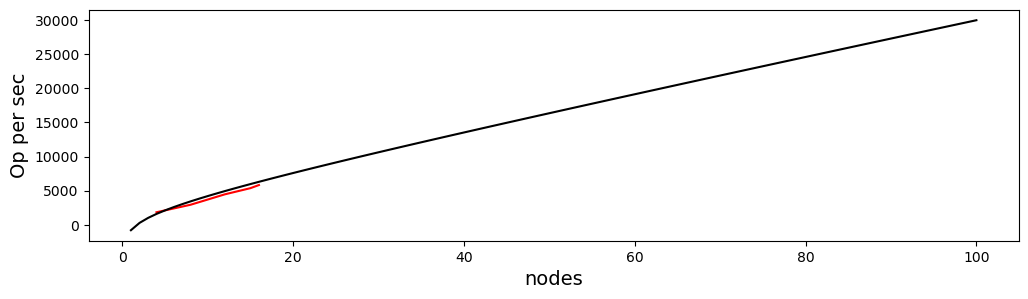

In [178]:
Z = np.array((
    [
        key[key_enum(parametr)] for key in list(Data.keys()) if compare(key, parametr, fix_params)
    ],
    [
        Data[key]['SUM_op/s'] for key in list(Data.keys()) if compare(key, parametr, fix_params)
    ]
)).T

# Построение предсказаний
x_range_size = np.linspace(8, 128e3, int(127993 * 10e-3))
x_range_nodes = np.linspace(0, 100, 100)
x_range_SSD = np.linspace(2, 4, 2)
x_range_protection_3REP = np.linspace(0, 1, 2)
x_range_protection_EC21 = np.linspace(0, 1, 2)
x_range_type_write = np.linspace(0, 1, 2)
x_range_HW_chassis_X205 = np.linspace(0, 1, 2)
X_range = np.array(np.meshgrid(
    x_range_nodes
    )).T.reshape(-1, 1)

Z = Z[Z[:, 0].argsort()].T

Z = np.array((
    [
        key[key_enum(parametr)] for key in list(Data.keys()) if compare(key, parametr, fix_params)
    ],
    [
        Data[key]['SUM_op/s'] for key in list(Data.keys()) if compare(key, parametr, fix_params)
    ]
)).T

y_pred_t = (
    np.mean(intercept_samples) + 
    np.mean(slope_size_linear_samples) * fix_params['size'] + np.mean(slope_size_gaussian_samples) * G(fix_params['size']) +
    np.mean(slope_nodes_linear_samples) * X_range[:, 0] + np.mean(slope_nodes_log_samples) * np.log(X_range[:, 0]) +
    np.mean(slope_SSD_samples) * 2 +
    np.mean(slope_protection_3REP_samples) * 1 +
    np.mean(slope_protection_EC21_samples) * 0 +
    np.mean(slope_type_write_samples) * 1 +
    np.mean(slope_HW_chassis_X205_samples) * 1
)

plt.figure(figsize=(12, 3)) 

plt.xscale('linear')

graph_title = {key: {'first graph': fix_params[key]} for key in list(doc.keys())}
plt.plot(Z[:, 0], Z[:, 1],'r-', alpha = 1)

plt.plot(X_range, y_pred_t,'k-', alpha = 1)
graph_title.pop(parametr, None)
print(f'params:\n{pd.DataFrame(graph_title).transpose()}')
plt.title('', fontsize=15)
plt.xlabel(parametr, fontsize=14, color='k')
plt.ylabel('Op per sec', fontsize=14, color='k')





In [170]:
Y_predicted = (
    np.mean(intercept_samples) + 
    np.mean(slope_size_linear_samples) * X[:, 0] + np.mean(slope_size_gaussian_samples) * G(X[:, 0]) +
    np.mean(slope_nodes_linear_samples) * X[:, 1] + np.mean(slope_nodes_log_samples) * np.log(X[:, 1]) +
    np.mean(slope_SSD_samples) * X[:, 2] +
    np.mean(slope_protection_3REP_samples) * X[:, 3] +
    np.mean(slope_protection_EC21_samples) * X[:, 4] +
    np.mean(slope_type_write_samples) * X[:, 5] +
    np.mean(slope_HW_chassis_X205_samples) * X[:, 6]
)
r_squared = 1 - (np.sum((Y - Y_predicted) ** 2) / np.sum((Y - np.mean(Y)) ** 2))
print(f'R²: {r_squared}')

rmse = np.sqrt(np.sum((Y_predicted-Y) ** 2) / len(Y))

print(f'RMSE: {rmse}')


R²: 0.5458664940244935
RMSE: 3110.1391073956293


## Summaries